# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

## Importing dependencies and define helper functions

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [2]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
data = env.reset()
print(data)
print(len(data))
observation, _ = data
print("Initial observations:", observation)
print(observation[0])

For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
#observation, reward, done, info = env.step(0)
data = env.step(0)
print(data)
print(len(data))
observation, reward, done, info, _ = data
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info, _ = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

## Step 0: Load the classes QState and QPolicy

In [4]:
import random
import copy
import math

def rand_policy_agent(observation):
    return random.randint(0, 1)

# Since the only two actions are going left and right, each Q-State stores the Q-values for both of those sections.
class QState:
  def __init__(self, left_val, right_val):
    self.left_val = left_val
    self.right_val = right_val

  def getLeft(self):
    return self.left_val

  def setLeft(self, val):
    self.left_val = val

  def getRight(self):
    return self.right_val

  def setRight(self, val):
    self.right_val = val

  def pick_action(self):
    return 0 if self.left_val > self.right_val else 1
    #return 0 if random.randint(0, math.ceil(self.left_val)+2) > random.randint(0, math.ceil(self.right_val)+2) else 1
  
  def __str__(self):
    return "(" + str(self.left_val) + ", " + str(self.right_val) + ")"
  
  def __repr__(self):
    return "(" + str(self.left_val) + ", " + str(self.right_val) + ")"


class QPolicy:

  def __init__(self):
    self.states = None
    self.QTable = {}
  
  # Maps an observation to a Q-State.
  # I came up with my very own hashing function, which takes an observation and rounds off each float inside the observation to 1 decimal point.
  def observationToIndex(self, observation):
    """
    Num Observation   Min   Max
    0   Cart Position -4.8  4.8
    1   Cart Velocity -Inf  Inf
    2   Pole Angle    ~-0.418 rad (-24°) ~0.418 rad (24°)
    3   Pole Angular Velocity -Inf Inf
    """

    index = tuple(map(lambda x: math.floor(x*10), observation))
    if index not in self.QTable:
      if len(self.QTable) < 100000:
        # During training, if a new observation is encountered, add a new entry to the Q-Table.
        self.QTable[index] = QState(0, 0)
      else:
        # If the observation is not in the table, find the closest Q-State that corresponds to that observation instead 
        min_key = (0, 0, 0, 0)
        for key in self.QTable.keys():
          if np.linalg.norm(np.array(min_key)-observation) < np.linalg.norm(np.array(key)-observation):
            min_key = key
        return self.QTable[min_key]

    return self.QTable[index]


  def initialise(self):
    self.QTable = {}

  # Takes the average score out of 100 trials.
  def evaluate(self):
    n = 100
    cumulative_reward = 0
    for i in range(n):
      observation, _ = env.reset()
      done = False
      while not done:
        data = env.step(self.observationToIndex(observation).pick_action())
        observation, reward, done, info, _ = data
        cumulative_reward += reward
    return cumulative_reward // n

  # Q-learning through a random trial.
  def trial(self):
    # According to https://en.wikipedia.org/wiki/Q-learning#Influence_of_variables a high alpha (learning rate) is appropriate as the gym environment is highly deterministic
    # and a high gamma (discount factor) is appropriate as the policy will make a long string of steps in the gym environment.
    a = 0.8
    g = 0.9

    done = False
    observation, _ = env.reset()
    while not done:
      action = self.observationToIndex(observation).pick_action()
      # take the other action once out of every 5 times
      if random.randint(1,5) == 5:
        action = 0 if action == 1 else 1
      data = env.step(action)
      next_observation, reward, done, info, _ = data

      # Since we cannot easily determine the next step only from the current step, we treat the previous step as s (current state) and the current step as s' (the next state) for the Q-formula
      ele = self.observationToIndex(observation)
      next_ele = self.observationToIndex(next_observation)
      
      # The formula Q(s, a) = Q(s, a) + a * (r + g * max_a'(s', a') - Q(s, a)), where s is an observation and a is going left or right
      if action == 0:
        ele.setLeft(ele.getLeft() + 
                    a * (reward + 
                    g * max(next_ele.getLeft(), next_ele.getRight())
                    - ele.getLeft()))
      elif action == 1:
        ele.setRight(ele.getRight() + 
                    a * (reward + 
                    g * max(next_ele.getLeft(), next_ele.getRight())
                    - ele.getRight()))
      observation = next_observation


## Step 1: Generate a blank q-learning model

In [5]:
policy = QPolicy()
policy.initialise()
print(policy.evaluate())

9.0


## Step 2: Load the Q-learning model from qpolicy.txt

In [6]:
policy = QPolicy()

with open("qpolicy.txt", "r") as f:
    for ele in f:
        stripped = ele.strip()
        tuple_string, qstate_string = stripped.split(":")
        tuple_string = tuple_string[1:-1]
        qstate_string = qstate_string[1:-1]

        key = tuple_string.split(", ")
        key = tuple(map(lambda x: int(x), key))
        
        left, right = qstate_string.split(", ")
        policy.QTable[key] = QState(float(left), float(right))

print(policy.evaluate())

427.0


## Step 3: Repeatedly train the q-learning model and save model data to qpolicy.txt

In [ ]:
for j in range(100000):
    for i in range(1000):
        policy.trial()
    with open("qpolicy.txt", "w") as f:
        for key, ele in policy.QTable.items():
            f.write(str(key) + ":" + str(ele) + "\n")

For Task 1, we can show the observation and chosen action below:

In [ ]:
observation, _ = env.reset()
action = policy.pick_action(observation)
print("Observation:", observation)
print("Chosen action:", action)

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

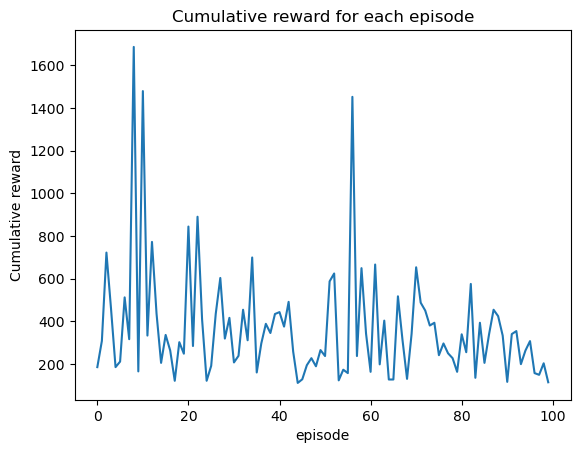

In [7]:
# I am aware that the simulation should end at step 500, but for some reason the cumulative reward goes beyond 1600 for some episodes
episode_results = []

n = 100
for i in range(n):
    cumulative_reward = 0
    observation, _ = env.reset()
    done = False
    while not done:
        data = env.step(policy.observationToIndex(observation).pick_action())
        observation, reward, done, info, _ = data
        cumulative_reward += reward
    episode_results.append(cumulative_reward)

episode_results = np.array(episode_results)

plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [8]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 367.3
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [11]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./video")
observation, _ = env.reset()
while True:
    #your agent goes here
    action = policy.observationToIndex(observation).pick_action()
    observation, reward, done, info, _ = env.step(action)
    if done:
      break;
env.close()
show_video()

MoviePy - Building video /Users/admin/Desktop/video/rl-video-episode-0.mp4.
MoviePy - Writing video /Users/admin/Desktop/video/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /Users/admin/Desktop/video/rl-video-episode-0.mp4
